# **Project 1: Survival Analysis and Prediction [30 points]**

Many clinical trials and observational studies involve following patients for a long time. The primary event of interest in those studies may include death, relapse, or the onset of a new disease. The follow-up time for a trial or a study may range from few weeks to many years. To analyze this data, we typically conduct time-to-event analysis and build predictive models that learn time-to-event distributions. The goal of this project is to test your ability to conduct basic survival analyses as well as develop ML models for survival prediction.

**Submitted by:** Franny Dean

Due: Tuesday 2/4 11:59 PST

## Task 1.1: Nonparametric Survival Analysis in Heart Failure [7 pts]

In [1]:
# %pip install lifelines

In [2]:
import pandas as pd
import numpy as np

from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index

from kaplan_meier import *
from exponential_survival import *


In [3]:
# Set display options:
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)  

dataset = pd.read_csv("data/heart_failure_clinical_records_dataset.csv")

In [4]:
dataset.head(10)
# Remark time is in days

# dataset.describe()
# Assignment says more males than women so because sex has mean 0.65, 1 == males

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
5,90.0,1,47,0,40,1,204000.00,2.1,132,1,1,8,1
6,75.0,1,246,0,15,0,127000.00,1.2,137,1,0,10,1
7,60.0,1,315,1,60,0,454000.00,1.1,131,1,1,10,1
8,65.0,0,157,0,65,0,263358.03,1.5,138,0,0,10,1
9,80.0,1,123,0,35,1,388000.00,9.4,133,1,1,10,1


#### 1.1.1

We fit a kaplan meier survival curve. 

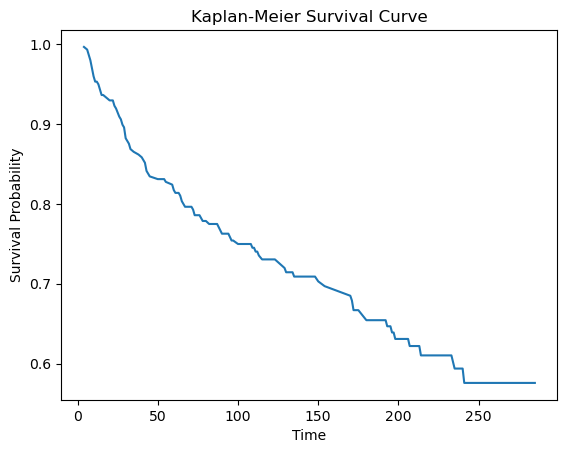

In [5]:
# Custom function to fit the Kaplan-Meier estimator
surv_dataframe = fit_km(dataset['time'],dataset['DEATH_EVENT'])
plot_km(surv_dataframe)

<Axes: xlabel='timeline'>

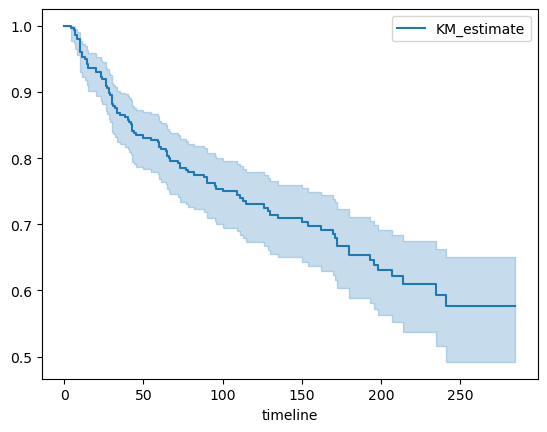

In [6]:
# Using lifelines package
kmf = KaplanMeierFitter()
kmf.fit(dataset['time'], event_observed=dataset['DEATH_EVENT'])
kmf.survival_function_
kmf.cumulative_density_
kmf.plot_survival_function()

We compare the survival estimate to one literature estimate of survival of patients with chronic heart failure. 

Jones et al 2019 Eur J Heart Fail.

*In our random effects meta-analyses the pooled survival rates at 1 month, 1, 2, 5 and 10 years were 95.7% (95% confidence interval 94.3-96.9), 86.5% (85.4-87.6), 72.6% (67.0-76.6), 56.7% (54.0-59.4) and 34.9% (24.0-46.8), respectively.*

Survival in our predicts from the Punjabi dataset are lower with predicted survival down to 60% at under a year. There are a wide variety of reasons for differences in predicted survival. The rates in a quick literature search are genearlly from the US and Europe, which may differ from Pakistan due to care access and practices.

#### 1.1.2

We propose fitting a parametric exponential survival model $S_{\lambda}$ of the form 

$$S_{\lambda}(t) = e^{-\lambda t}$$

where $\lambda =$ rate of decay with continuous time $t$ in survival. This is 1 - the CDF of the exponential distribution for the event of death from heart failure. The PDF for this distribution is $f_{\lambda}(t) = \lambda e^{-\lambda t}$. We seek to fit the parameter $\lambda$ with a minimization task. We choose to minimize the log of the liklihood, i.e. maximize the liklihood of the model $f_{\lambda}(t)$ given our data $\mathcal{D}=\{T_i, E_i, C_i\}$.

For our censored set up, we break up the derivation of the liklihood function for $f_{\lambda}(t)$ into two cases. First, if $C_i=0$, we do not know when the event modeled by $f_{\lambda}(t)$ occurs, but we know the individual survives to time $T_i$. thus, we write the liklihood of this as $$S(T_i) = e^{-\lambda T_i}.$$ If $C_i=1$, then we have the liklihood is $$f(T_i) = \lambda e^{-\lambda T_i}.$$ The full liklihood is then 

\begin{align}
(e^{-\lambda T_i})^{1-C_i}(\lambda e^{-\lambda T_i})^{C_i}\\
e^{-\lambda T_i + \lambda T_i C_i}\lambda^{C_i} e^{-\lambda T_i C_i} \\
e^{-\lambda T_i }\lambda^{C_i}.
\end{align}

Thus, we seek to maximize the following to leverage all data

$$\max_{\lambda\in \mathbb{R}} L(\lambda) =\max_{\lambda\in \mathbb{R}}  \prod_{i=1}^{|\mathcal{D}|} e^{-\lambda T_i }\lambda^{C_i}$$

which is equivilantly the minimization task

$$\min_{\lambda\in \mathbb{R}}\log L(\lambda) =  \min_{\lambda\in \mathbb{R}}\sum_{i=1}^{|\mathcal{D}|} \log( e^{-\lambda T_i }\lambda^{C_i}).$$

In this fun special case, we can avoid gradient descent by writing the closed form solution to the task. Notice that

\begin{align}
\log L(\lambda) &=\sum_{i=1}^{|\mathcal{D}|} -\lambda T_i + C_i\log(\lambda)\\
&=\sum_{i=1}^{|\mathcal{D}|} -\lambda T_i + C_i\log(\lambda)\\
\frac{\partial \log L(\lambda)}{\partial \lambda} & = \sum_{i=1}^{|\mathcal{D}|} - T_i + \frac{C_i}{\lambda}
\end{align}

Then, $\lambda = \frac{\sum_{i=1}^{|\mathcal{D}|} {C_i}}{\sum_{i=1}^{|\mathcal{D}|} {T_i}}$ gives a zero first derivative, which turns out to be a minimum as $\frac{\partial^2\log L(\lambda)}{\partial^2 \lambda} = -\sum_{i=1}^{|\mathcal{D}|}\frac{C_i}{\lambda^2}$.

This model has the limitation that it assumes fixed rate of change. This means that if for example, patients who survived past 5 years suddenly had a start change in rate of death due to either a stark improvement or increased risk, this would not be captured by the model and hidden to providers.

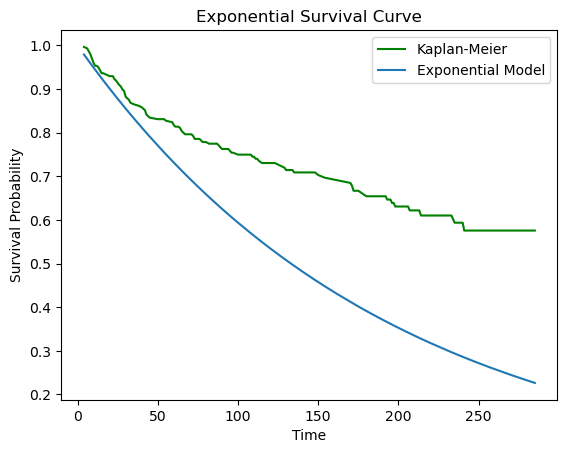

In [7]:
# Use exponential_survival class to fit this model
exp_model = exp_survival_model(dataset)
exp_model.plot_survival_curve()

#### 1.1.3

I propose calculating the k nearest neighbors based on simple Euclidean distance between a collection of covariates between the prediction individual and the dataset. From these k nearest neighbors a standard kaplan meier curve is estimated.

Individual # 10 survival curve predicted from 100 nearest neighbors:


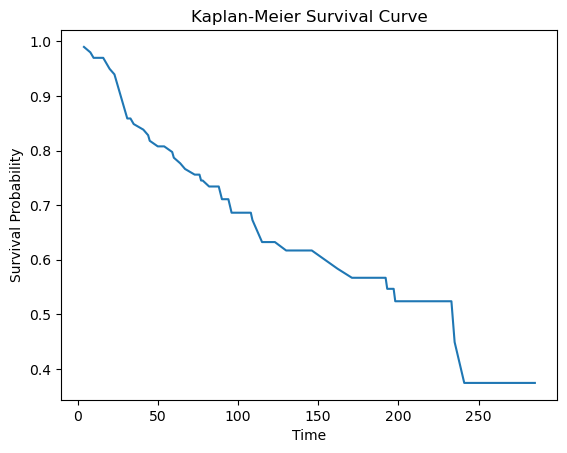

True time to event or censoring: 10 days.
This patient's event status: 1.
Predicted survival at time of event or censoring: 0.97
Concordance index: 0.9894125683060109
Individual # 20 survival curve predicted from 100 nearest neighbors:


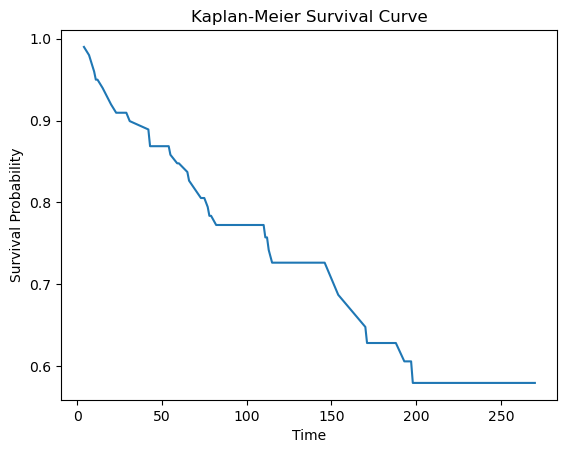

True time to event or censoring: 16 days.
This patient's event status: 0.
Predicted survival at time of event or censoring: 0.9398936170212766
Concordance index: 0.9837777777777778
Individual # 50 survival curve predicted from 100 nearest neighbors:


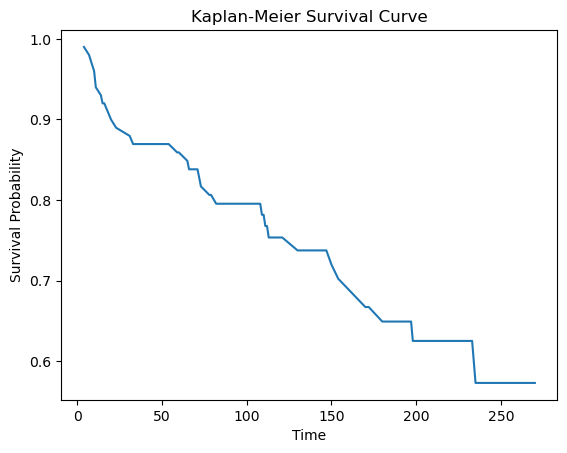

True time to event or censoring: 43 days.
This patient's event status: 1.
Predicted survival at time of event or censoring: 0.8694505494505494
Concordance index: 0.9842726081258192
Individual # 100 survival curve predicted from 100 nearest neighbors:


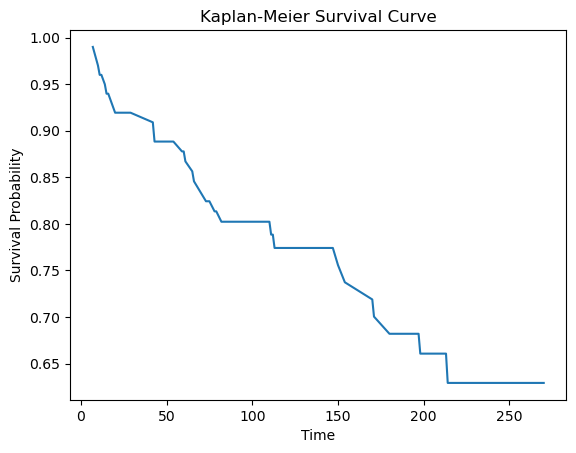

True time to event or censoring: 87 days.
This patient's event status: 0.
Predicted survival at time of event or censoring: 0.8022813368881757
Concordance index: 0.9809027777777778


In [8]:
# Normalize non-binary features
covariates = ['platelets','age','creatinine_phosphokinase','ejection_fraction','serum_creatinine','serum_sodium']
normalized_dataset = normalize_features(dataset, covariates)

covariates.extend(['sex','anaemia','diabetes','high_blood_pressure','smoking'])

k = 100
# Run individual survival prediction for various individuals
for individual in [10, 20, 50, 100]:
    print(f'Individual # {individual} survival curve predicted from {k} nearest neighbors:')
    output = fit_k_nn_km(k=k, df=normalized_dataset, idx=individual, covariates=covariates)
    plot_km(output)

    # Individual ground truth
    individual_time = dataset['time'].iloc[individual]
    individual_event = dataset['DEATH_EVENT'].iloc[individual]
    print(f"True time to event or censoring: {individual_time} days.")
    print(f"This patient's event status: {individual_event}.")

    # Predicted survival at time of event or censoring
    if individual_time in output['T'].values:
        predicted_value = output['S'][output['T'] == individual_time].values[0]
    else:
        # Find the closest time before the individual_time
        closest_time_idx = np.max(np.where(output['T'] < individual_time))
        closest_time = output['T'].iloc[closest_time_idx]
        predicted_value = output['S'][output['T'] == closest_time].values[0]
    print(f"Predicted survival at time of event or censoring: {predicted_value}")
    
    # Concordance index for the individual with prediction population
    output_w_ground_truth = pd.concat([output, pd.Series([individual_time, predicted_value, individual_event], index=['T','S','E']).to_frame().T])
    c_index = concordance_index(output_w_ground_truth['T'], -output_w_ground_truth['S'], output_w_ground_truth['E'])
    print(f"Concordance index: {c_index}")


## Task 1.2: Survival Prediction in HF patients using the Cox Model [7 pts]

#### 1.2.1

In [9]:
from cox_ph_model import *

#dataset[covariates] = (dataset[covariates] - dataset[covariates].mean()) / dataset[covariates].std()

custom_cox_model = custom_cox_model(dataset, covariates)
custom_cox_model.fit()
custom_cox_model.get_hazard_ratios()

Initialized with 11 covariates
Epoch [10/100], Negative Log-Likelihood: 492.636962890625
Epoch [20/100], Negative Log-Likelihood: 484.8108825683594
Epoch [30/100], Negative Log-Likelihood: 479.4750671386719
Epoch [40/100], Negative Log-Likelihood: 475.9169616699219
Epoch [50/100], Negative Log-Likelihood: 473.36334228515625
Epoch [60/100], Negative Log-Likelihood: 471.5813293457031
Epoch [70/100], Negative Log-Likelihood: 470.3481750488281
Epoch [80/100], Negative Log-Likelihood: 469.5079040527344
Epoch [90/100], Negative Log-Likelihood: 468.95361328125
Epoch [100/100], Negative Log-Likelihood: 468.5969543457031
Fitting done. Final loss: 468.5969543457031
<generator object Module.parameters at 0x141b2ece0>
torch.Size([11, 11])


,covariate,hazard_ratio,beta
0,platelets,0.956619,-0.044350
1,age,1.716752,0.540434
2,creatinine_phosphokinase,1.229167,0.206337
3,ejection_fraction,0.632413,-0.458212
4,serum_creatinine,1.376717,0.319701
5,serum_sodium,0.805964,-0.215716
6,sex,0.825474,-0.191798
7,anaemia,1.550541,0.438604
8,diabetes,1.144118,0.134634
9,high_blood_pressure,1.625061,0.485546


In [10]:
print(f"Concordance index: {custom_cox_model.concordance_index()}")

Concordance index: 0.7394017955734793


In [11]:
# Compare to lifelines package
from lifelines import CoxPHFitter

cph = CoxPHFitter()
covariates = ['platelets','age','creatinine_phosphokinase','ejection_fraction','serum_creatinine','serum_sodium',
              'sex','anaemia','diabetes','high_blood_pressure','smoking','time','DEATH_EVENT']
cph.fit(dataset[covariates], duration_col='time', event_col='DEATH_EVENT')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 299 total observations, 203 right-censored observations>
             duration col = 'time'
                event col = 'DEATH_EVENT'
      baseline estimation = breslow
   number of observations = 299
number of events observed = 96
   partial log-likelihood = -468.23
         time fit was run = 2025-02-01 17:27:48 UTC

---
                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                        
platelets                 -0.05       0.96       0.11            -0.26             0.17                 0.77                 1.19
age                        0.55       1.74       0.11             0.33             0.77                 1.40                 2.16
creatinine_phosphokinase   0.21       1.24       0.10             0.03             0.40                 1.03                 1.50
ejection_fraction         -0.58       0.56       0.12            -0.82            -0.34                 0.44                 0.71
serum_creatinine           0.33       1.39       0.07             0.19             0.47                 1.21                 1.61
serum_sodium              -0.19       0.82       0.10            -0.40             0.01                 0.67                 1.01
sex                       -0.24       0.79       0.25            -0.73             0.26                 0.48                 1.29
anaemia                    0.46       1.58       0.22             0.04             0.89                 1.04                 2.42
diabetes                   0.14       1.15       0.22            -0.30             0.58                 0.74                 1.78
high_blood_pressure        0.48       1.61       0.22             0.05             0.90                 1.05                 2.46
smoking                    0.13       1.14       0.25            -0.36             0.62                 0.70                 1.86

                           cmp to     z      p   -log2(p)
covariate                                                
platelets                    0.00 -0.41   0.68       0.56
age                          0.00  4.98 <0.005      20.56
creatinine_phosphokinase     0.00  2.23   0.03       5.26
ejection_fraction            0.00 -4.67 <0.005      18.35
serum_creatinine             0.00  4.58 <0.005      17.68
serum_sodium                 0.00 -1.90   0.06       4.12
sex                          0.00 -0.94   0.35       1.53
anaemia                      0.00  2.12   0.03       4.89
diabetes                     0.00  0.63   0.53       0.91
high_blood_pressure          0.00  2.20   0.03       5.17
smoking                      0.00  0.51   0.61       0.72
---
Concordance = 0.74
Partial AIC = 958.46
log-likelihood ratio test = 81.95 on 11 df
-log2(p) of ll-ratio test = 40.56

The effect of a one-year increase in age is the effect of a 365 unit increase in time. Given that the coefficient of age is 0.55 which exponentiated is 1.74. This means that for each day we have a 1.74 fold increase in the hazard or risk of heart failure. This would be 365*1.74 for one year. We remark that given that the longest follow up is 285 days this may not be an accurate extrapolation from our data.

#### 1.2.2

The concordance index of the above model is 0.74. A concordance index above 0.5 means better than random prediction based on the ordering. A value of 1.0 would be perfect model concordance.

Concordance index is a measure of how well the model respects the correct ordering of events. The AUC-ROC metric measures the area under the plot of true positive rate versus false positive rate. It indicates the models ability to pick out positive and negative cases accurately. This is less applicable in the survival setting because we want time to event rather than whether the event occurred. You could calculate AUC-ROC at a series of discrete time steps though and take an average.

#### 1.2.3

In [12]:
# Female model
females = dataset['sex'] == 0
cph = CoxPHFitter()
covariates = ['platelets','age','creatinine_phosphokinase','ejection_fraction','serum_creatinine','serum_sodium',
              'anaemia','diabetes','high_blood_pressure','smoking','time','DEATH_EVENT']
cph.fit(dataset[females][covariates], duration_col='time', event_col='DEATH_EVENT')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 105 total observations, 71 right-censored observations>
             duration col = 'time'
                event col = 'DEATH_EVENT'
      baseline estimation = breslow
   number of observations = 105
number of events observed = 34
   partial log-likelihood = -130.60
         time fit was run = 2025-02-01 17:27:49 UTC

---
                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                        
platelets                 -0.22       0.80       0.19            -0.60             0.15                 0.55                 1.17
age                        0.54       1.72       0.22             0.11             0.98                 1.11                 2.65
creatinine_phosphokinase   0.35       1.41       0.32            -0.29             0.98                 0.75                 2.66
ejection_fraction         -0.45       0.64       0.20            -0.84            -0.06                 0.43                 0.94
serum_creatinine           0.33       1.39       0.12             0.10             0.55                 1.11                 1.74
serum_sodium              -0.30       0.74       0.21            -0.71             0.10                 0.49                 1.10
anaemia                    0.86       2.36       0.39             0.09             1.63                 1.10                 5.10
diabetes                   0.52       1.69       0.41            -0.29             1.33                 0.75                 3.78
high_blood_pressure        0.40       1.50       0.36            -0.29             1.10                 0.75                 3.01
smoking                    1.37       3.93       0.69             0.01             2.72                 1.01                15.22

                           cmp to     z      p   -log2(p)
covariate                                                
platelets                    0.00 -1.16   0.24       2.03
age                          0.00  2.45   0.01       6.12
creatinine_phosphokinase     0.00  1.07   0.28       1.82
ejection_fraction            0.00 -2.25   0.02       5.35
serum_creatinine             0.00  2.84 <0.005       7.80
serum_sodium                 0.00 -1.47   0.14       2.83
anaemia                      0.00  2.19   0.03       5.14
diabetes                     0.00  1.27   0.20       2.29
high_blood_pressure          0.00  1.14   0.26       1.97
smoking                      0.00  1.98   0.05       4.39
---
Concordance = 0.74
Partial AIC = 281.20
log-likelihood ratio test = 29.37 on 10 df
-log2(p) of ll-ratio test = 9.85

In [13]:
# Male model
males = dataset['sex'] == 1
cph = CoxPHFitter()
covariates = ['platelets','age','creatinine_phosphokinase','ejection_fraction','serum_creatinine','serum_sodium',
              'anaemia','diabetes','high_blood_pressure','smoking','time','DEATH_EVENT']
cph.fit(dataset[males][covariates], duration_col='time', event_col='DEATH_EVENT')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 194 total observations, 132 right-censored observations>
             duration col = 'time'
                event col = 'DEATH_EVENT'
      baseline estimation = breslow
   number of observations = 194
number of events observed = 62
   partial log-likelihood = -270.72
         time fit was run = 2025-02-01 17:27:49 UTC

---
                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                        
platelets                  0.10       1.10       0.14            -0.17             0.37                 0.84                 1.44
age                        0.61       1.83       0.14             0.34             0.87                 1.40                 2.39
creatinine_phosphokinase   0.17       1.19       0.10            -0.03             0.38                 0.97                 1.46
ejection_fraction         -0.73       0.48       0.17            -1.07            -0.40                 0.34                 0.67
serum_creatinine           0.28       1.32       0.11             0.06             0.49                 1.06                 1.64
serum_sodium              -0.13       0.87       0.14            -0.42             0.15                 0.66                 1.16
anaemia                    0.17       1.18       0.28            -0.37             0.71                 0.69                 2.03
diabetes                  -0.15       0.86       0.29            -0.71             0.41                 0.49                 1.51
high_blood_pressure        0.42       1.52       0.28            -0.12             0.97                 0.88                 2.63
smoking                   -0.08       0.92       0.26            -0.60             0.43                 0.55                 1.54

                           cmp to     z      p   -log2(p)
covariate                                                
platelets                    0.00  0.71   0.48       1.07
age                          0.00  4.43 <0.005      16.70
creatinine_phosphokinase     0.00  1.67   0.10       3.38
ejection_fraction            0.00 -4.30 <0.005      15.87
serum_creatinine             0.00  2.49   0.01       6.29
serum_sodium                 0.00 -0.93   0.35       1.52
anaemia                      0.00  0.61   0.54       0.88
diabetes                     0.00 -0.52   0.60       0.73
high_blood_pressure          0.00  1.52   0.13       2.95
smoking                      0.00 -0.32   0.75       0.41
---
Concordance = 0.76
Partial AIC = 561.44
log-likelihood ratio test = 61.71 on 10 df
-log2(p) of ll-ratio test = 29.11


I trained separate cox proportional hazard models for males and females and compare the size of the coefficients of age. The coefficient for age in the male model is 0.61 with 95% confidence interval 0.34-0.87. The coefficient for age in the female model is 0.54 with 95% confidence interval	(0.11-0.98). This suggests that the difference in age when controlling for other covariates is not a statistically significantly larger increase in hazard.

## Task 1.3: Deep Survival Prediction for Heart Transplantation [8 pts]

####  Setup and Dataset

For this task, we will use data collected by the United Network for Organ Sharing (UNOS) [2], a non-profit organization that administers the only Organ Procurement and Transplantation Network (OPTN) in the US. UNOS is involved in many aspects of the organ transplant and donation process in the US, including data collection and maintenance, providing assitance to patients and care takers, and informing policy makers on the best use of the limited supply of organs and give all patients a fair chance at receiving the organ they need. UNOS manages the heart transplant waiting list, i.e., the list of terminally-ill patients waiting for donor heart. In order to determine the order of priority for receipt of a donor heart, individuals are classified by degrees of severity for a donor heart, blood type, body weight, and geographic location.

This Task will focus on the cohort of terminally-ill patients who are enrolled in the wait-list for heart transplantation. In this setup, our goal is to predict the patients who are less likely to survive in order to prioritize them for receiving donated organs. The UNOS data covers 30 years of heart transplantation data in the US, spanning the years from 1985 to 2015. We will use data for patients who were on the wait-list for heart transplantation in the US from 1985 to 2010 (27,926 patients) to train an ML-based model for predicting individual-level survival. A held-out test set of 8,403 patients enrolled in the wait-list between 2010 and 2015 will be used by the instructor to evaluate your model. You can load the UNOS data in pandas as follows.

In [14]:
UNOS_data           = pd.read_csv("data/UNOS_train.csv")

In [15]:
UNOS_data.head()

,Unnamed: 0,wl_id_code,init_age,gender,hgt_cm_tcr,wgt_kg_tcr,diab,prev_tx,num_prev_tx,ventilator_tcr,ecmo_tcr,most_rcnt_creat,abo_A,abo_B,abo_O,abo_AB,iabp_tcr,days_stat1,days_stat1a,days_stat2,days_stat1b,init_bmi_calc,vad_while_listed,tah,inotropic,init_date,end_date,Censor (Censor = 1),Survival Time
0,0,190772,58,1,168.00,70.00,0,0,0,0,0,1.1,0,0,1,0,0,25,0,0,0,24.801587,0,0,0,2/28/1994,3/25/1994,0,25
1,1,763510,0,1,53.00,3.70,0,1,1,0,0,0.4,0,1,0,0,0,2,0,0,0,13.171947,0,0,0,2/28/1994,3/2/1994,1,2
2,2,39269,39,1,160.00,80.00,0,0,0,0,0,0.8,1,0,0,0,0,0,0,112,0,31.250000,0,0,0,3/2/1994,6/18/1999,0,1934
3,3,656721,41,1,170.18,63.96,0,0,0,0,0,1.3,0,0,1,0,0,0,0,428,0,22.084696,0,0,0,1/23/1991,7/25/1997,0,2375
4,4,196059,22,1,165.00,61.00,0,0,0,0,0,0.8,0,0,1,0,0,0,0,536,0,22.405877,0,0,0,11/11/1992,5/20/1994,0,555


#### Feature Dictionary

Each patient's record in the UNOS database is associated with the following variables:

The interpretation of each variable is provided below:

- "init_age": Patient's age at time of enrolling in the wait-list
- "gender": Patient's biological sex
- "hgt_cm_tcr": Patient's height in cm
- "wgt_kg_tcr": Patient's weight in kgs
- "diab": Indication on whether or not the patient is diabetic
- "abo_A": Indication on whether patient's blood type is A
- "abo_B": Indication on whether patient's blood type is B
- "abo_O": Indication on whether patient's blood type is O
- "ventilator_tcr": Indication on whether the patient was dependent on a ventilator at time of enrollment in the wait-list
- "ecmo_tcr": Indication on whether the patient was treated with ECMO (extracorporeal membrane oxygenation) by the time they where enrolled in the wait-list. ECMO is an artificial life support that continuously pumps blood out of the patient's body and sends it through a series of devices that add oxygen and remove carbon dioxide, pumping the blood back to the patient. It is used for a patient whose heart and lungs are not functioning properly.  
- "most_rcnt_creat": Creatinine level in the patient's most recent blood test before enrolling in wait-list.
- "vad_while_listed": Whether the patient was on ventricular assist device (VAD) support when listed for a heart transplant. VAD is a mechanical pump used to restore cardiac function by pumping blood from the lower chambers of the heart to the rest of the body.
- "iabp_tcr": Whether the patient was on Intra-Aortic Balloon Pump (IABP) Therapy. This is a therapeutic device used to improve blood flow when the heart is unable to pump enough blood for your body.
- "init_bmi_calc": Patient's Body Mass Index at time of enrollment in the wait-list.
- "tah": Whether the patient underwent a total artificial heart (TAH) surgery. This is a mechanical pump that replaces the heart when it is not working as it should.
- "inotropic": Whether the patient was on an Inotropic drug at time of enrollment in wait-list. These are medicines that change the force of the heart's contractions.
- "days_stat1", "days_stat1a", "days_stat1b", "days_stat2": UNOS has an internal system for classifying the priority of patients for receiving a heart transplant. Individuals classified as Status 1A have the highest priority on the heart transplant waiting list. Status 1A are individuals who must stay in the hospital as in-patients and require high doses of intravenous drugs, require a VAD for survival, are dependent on a ventilator or have a life expectancy of a week or less without a transplant. Individuals classified as Status 1B are generally not required to stay in the hospital as in-patients. All other candidates for the transplant are listed under Status 2. These variables indicate the number of days a patient spends in each status during the time between their enrollment in the wait-list and death or reception of a transplant.
- "Censor (Censor = 1)": Indication of censoring
- "Survival Time": Time between enrollment in wait-list and death

In [16]:
# Drop negative survival times
UNOS_data = UNOS_data[UNOS_data['Survival Time']>=0]

#### 1.3.1

In [17]:
patient_variables   = ["init_age", "gender","hgt_cm_tcr", "wgt_kg_tcr", 
                       "diab", "ventilator_tcr", "ecmo_tcr", "most_rcnt_creat", 
                       "abo_A", "abo_B", "abo_O", "vad_while_listed",
                       #"days_stat1", "days_stat1a", "days_stat2", "days_stat1b", 
                       "iabp_tcr","init_bmi_calc", "tah", "inotropic"] 
                       #"Censor (Censor = 1)", "Survival Time"]
# Normalize age, height, weight, creatinine, bmi
UNOS_data["init_age"] = (UNOS_data["init_age"] - UNOS_data["init_age"].mean()) / UNOS_data["init_age"].std()
UNOS_data["hgt_cm_tcr"] = (UNOS_data["hgt_cm_tcr"] - UNOS_data["hgt_cm_tcr"].mean()) / UNOS_data["hgt_cm_tcr"].std()
UNOS_data["wgt_kg_tcr"] = (UNOS_data["wgt_kg_tcr"] - UNOS_data["wgt_kg_tcr"].mean()) / UNOS_data["wgt_kg_tcr"].std()
UNOS_data["most_rcnt_creat"] = (UNOS_data["most_rcnt_creat"] - UNOS_data["most_rcnt_creat"].mean()) / UNOS_data["most_rcnt_creat"].std()
UNOS_data["init_bmi_calc"] = (UNOS_data["init_bmi_calc"] - UNOS_data["init_bmi_calc"].mean()) / UNOS_data["init_bmi_calc"].std()

Of these potential features, I will exclude "days_stat1", "days_stat1a", "days_stat1b", "days_stat2" due to the fact that these assumes a predefined grouping of patients by risk. 

I choose to implement a deep learning survival model which uses a MLP to predict both the hazard function for each patient from the covariates $X$ and time $t$ and the baseline hazard dependent on time $t$. The key adaptation of this model from the cox proportional hazard is the relaxation of the linear assumption on the impact of the covariates on the hazard function. By using a neural network, the model can learn non-linear relationships between the covariates and the death risk. This model most closely resembles the 2019 Cox-Time model presented in lecture. The loss is the log likelihood loss.

#### 1.3.2

In [18]:
# Split the UNOS data into training and testing sets
train = UNOS_data.sample(frac=0.8, random_state=42)
test = UNOS_data.drop(train.index)
print(len(train), len(test))

22331 5583


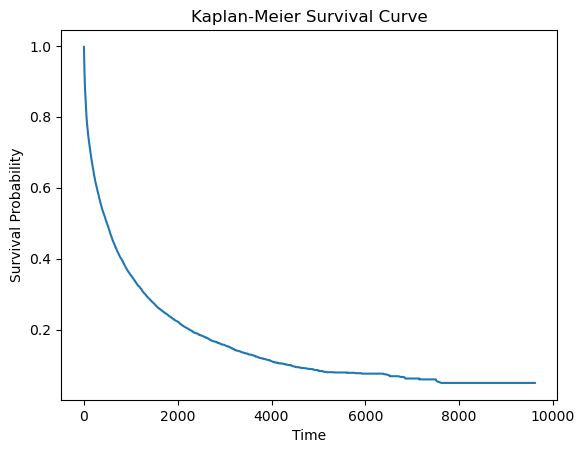

In [19]:
# Kaplan-Meier estimator
surv_dataframe = fit_km(train['Survival Time'], 1-train['Censor (Censor = 1)'])
plot_km(surv_dataframe)

In [20]:
# Deep survival model
from deep_survival import *

DeepSurvivalModel = SurvivalModel(df = train, covariates = patient_variables)
DeepSurvivalModel.fit(epochs = 100, batch_size=64)

Hazard model initializing...
SurvivalModel initialized.
Fitting DeepSurv model...
Epoch 0, Loss: 28.0239
Epoch 10, Loss: 21.0024
Epoch 20, Loss: 21.0004
Epoch 30, Loss: 18.0002
Epoch 40, Loss: 18.0007
Epoch 50, Loss: 21.0033
Epoch 60, Loss: 25.0005
Epoch 70, Loss: 22.0001
Epoch 80, Loss: 20.0001
Epoch 90, Loss: 30.0002
Fitting done.


Training concordance index:
0.5116127995204172
Testing concordance index:
0.8029355893576212
0.7875122768155624
Predicting survival probabilities...
[3.67340773e-01 1.34950683e-01 4.95782234e-02 1.82140023e-02
 6.69172453e-03 2.45854305e-03 9.03297914e-04 3.31890915e-04
 1.21946854e-04 4.48080864e-05 1.64646135e-05 6.05001969e-06
 2.22316862e-06 8.16956913e-07 3.00216811e-07 1.10326006e-07
 4.05446166e-08 1.49003085e-08 5.47607559e-09 2.01256434e-09]


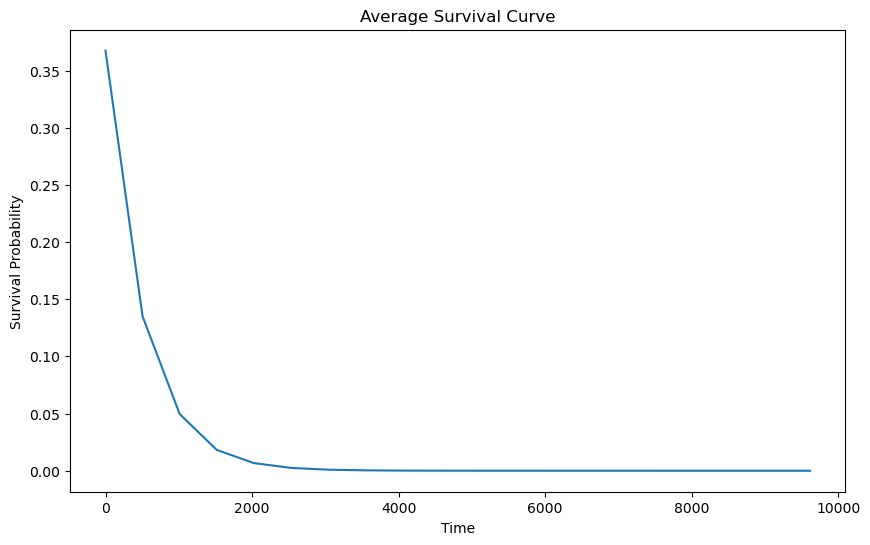

Predicting survival probabilities...
[3.67416710e-01 1.34972513e-01 4.95901965e-02 1.82153583e-02
 6.69399183e-03 2.45951465e-03 9.03657114e-04 3.31984455e-04
 1.21988014e-04 4.48284154e-05 1.64744361e-05 6.05337118e-06
 2.22456129e-06 8.17513978e-07 3.00423750e-07 1.10405175e-07
 4.05723810e-08 1.49107890e-08 5.48018431e-09 2.01408579e-09]


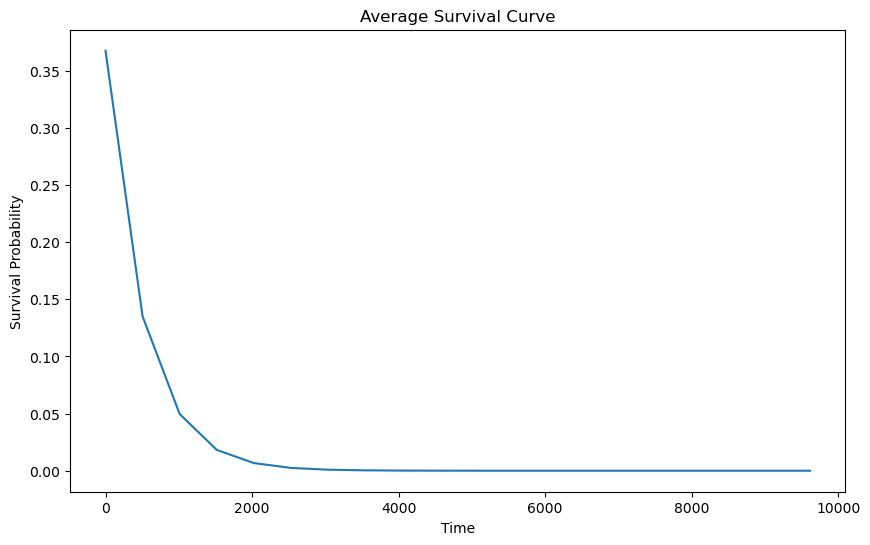

In [21]:
print('Training concordance index:')
print(DeepSurvivalModel.faster_concordance_index(train)) # Concordance index takes so long :(

print('Testing concordance index:')
#DeepSurvivconsidalModel.predict(test)
print(DeepSurvivalModel.concordance_index(test))
print(DeepSurvivalModel.faster_concordance_index(test))

# Plot average survival curve
DeepSurvivalModel.plot_average_survival(test)
DeepSurvivalModel.plot_average_survival(train)

### Results for the 1_31_2025 best weights
# Training concordance index:
# 0.5116127995204172
# Testing concordance index:
# 0.8029355893576212
# 0.7875122768155624

This model is calibrated sort of poorly... 

In [22]:
torch.save(DeepSurvivalModel.state_dict(), 'deep_survival_model_weights_2_1_2025.pth')

For easy testing of concordance on new data:

In [23]:
# # Load the model
# FILEPATH = '' # Path to test data
# test = pd.read_csv(FILEPATH)

# # Preprocessing includes normalizing the data and dropping negative survival times
# # Normalize age, height, weight, creatinine, bmi
# test = test[test['Survival Time']>=0]
# test["init_age"] = (test["init_age"] - test["init_age"].mean()) / test["init_age"].std()
# test["hgt_cm_tcr"] = (test["hgt_cm_tcr"] - test["hgt_cm_tcr"].mean()) / test["hgt_cm_tcr"].std()
# test["wgt_kg_tcr"] = (test["wgt_kg_tcr"] - test["wgt_kg_tcr"].mean()) / test["wgt_kg_tcr"].std()
# test["most_rcnt_creat"] = (test["most_rcnt_creat"] - test["most_rcnt_creat"].mean()) / test["most_rcnt_creat"].std()
# test["init_bmi_calc"] = (test["init_bmi_calc"] - test["init_bmi_calc"].mean()) / test["init_bmi_calc"].std()

# DeepSurvivalModel = SurvivalModel(df = test, covariates = patient_variables)
# DeepSurvivalModel.load_state_dict(torch.load('deep_survival_model_weights_1_31_2025.pth'))

# # Calculate concordance index
# print(f'Concordance index on new data: {DeepSurvivalModel.concordance_index(test)}')

# # Plot average curve
# DeepSurvivalModel.plot_average_survival(test)

## Task 1.4: Handling Informative Censoring via Domain Adaptation [8 pts]

#### 1.4.1

Methods for survival estimation often assume that censoring is random or otherwise not correlated with survival time or patient features. We test the censoring assumption by comparing the distribution of covariates across the censored and uncensored individuals.

In [24]:
from pycox import datasets
import scipy.stats as stats

# Dictionary of the column names
key_col_names = {
    'gbsg': ['duration', 'event'],
    'metabric': ['duration', 'event'],
    'nwtco': ['edrel', 'rel'],
    'support': ['duration', 'event'],
    'flchain': ['futime', 'death']
}

# Check datasets one at a time
for pycox_dataset in ['gbsg', 'metabric', 'nwtco', 'support', 'flchain']:
    print(f'Checking {pycox_dataset} dataset')
    if pycox_dataset in ['flchain','nwtco']:
        df = getattr(datasets, pycox_dataset).read_df(processed=False)
    else:
        df = getattr(datasets, pycox_dataset).read_df()
    
    event_col=key_col_names[pycox_dataset][1]
    duration_col=key_col_names[pycox_dataset][0]

    # Handling non-numerical columns
    if pycox_dataset=='nwtco':
        df = df.drop(['in.subcohort'], axis=1)

    if pycox_dataset=='flchain':
        df = pd.get_dummies(df, columns=['chapter', 'sex'], drop_first=True)
    
    
    # Loop through covariates and compare their distributions
    different = False
    columns_differing = []
    for column in df.columns.drop([event_col, duration_col]):
        if not np.issubdtype(df[column].dtype, np.number):
            print(f"Skipping non-numeric column: {column}")
            continue

        group_censored = df[df[event_col] == 0][column].dropna()
        group_event = df[df[event_col] == 1][column].dropna()

        if len(group_censored) > 1 and len(group_event) > 1:  # Ensure valid sample sizes
            t_stat, p_value = stats.ttest_ind(group_censored, group_event, equal_var=False)  # Welch’s t-test
            # print(f"{column}: t-stat={t_stat:.3f}, p-value={p_value:.5f}")

            if p_value < 0.05:
                columns_differing.append(column)
                different = True
    if different:
        print(f"Significant difference in {columns_differing} between event groups.")
    
    #df.head()


Checking gbsg dataset
Significant difference in ['x0', 'x1', 'x2', 'x3', 'x4', 'x5'] between event groups.
Checking metabric dataset
Significant difference in ['x0', 'x1', 'x2', 'x3', 'x5', 'x6', 'x8'] between event groups.
Checking nwtco dataset
Significant difference in ['rownames', 'seqno', 'instit', 'histol', 'stage', 'age'] between event groups.
Checking support dataset
Significant difference in ['x0', 'x1', 'x2', 'x3', 'x5', 'x6', 'x7', 'x10', 'x13'] between event groups.
Checking flchain dataset
Skipping non-numeric column: chapter_Circulatory
Skipping non-numeric column: chapter_Congenital
Skipping non-numeric column: chapter_Digestive
Skipping non-numeric column: chapter_Endocrine
Skipping non-numeric column: chapter_External Causes
Skipping non-numeric column: chapter_Genitourinary
Skipping non-numeric column: chapter_Ill Defined
Skipping non-numeric column: chapter_Infectious
Skipping non-numeric column: chapter_Injury and Poisoning
Skipping non-numeric column: chapter_Menta

All of the datasets differed by the considered measure of having a least one covariate whose distribution is statistically different (by comparing means with a Welch t test).

To address this, we create a synthetic dataset for each of these pycox datasets where the distribution of the feature of the censored group is better represented in the training data. We do this by fitting a linear regression model trained in the uncensored data to predict the time to event for each of the censored patients. We then add this collection of synthetic data to add weight to the censored patients covariate distributions leveraging the labeled event data. This method assumes that the feature's supports overlap and that the distribution of the censored patients is covered in a subsample of the uncensored patients.

In [25]:
from sklearn.linear_model import LinearRegression
from deep_survival import *

synthetic_dfs = {}

# Check datasets one at a time
for pycox_dataset in ['gbsg', 'metabric', 'nwtco', 'support', 'flchain']:
    print(f'Creating synthetic {pycox_dataset} dataset...')
    
    if pycox_dataset in ['flchain','nwtco']:
        df = getattr(datasets, pycox_dataset).read_df(processed=False)
    else:
        df = getattr(datasets, pycox_dataset).read_df()
    
    print(f'Original length of {pycox_dataset} dataset: {len(df)}.')
    
    event_col=key_col_names[pycox_dataset][1]
    duration_col=key_col_names[pycox_dataset][0]
    
    # Fit a model predicting the time to event as a function of the covariates
    model = LinearRegression()
    

    # Handling non-numerical columns
    if pycox_dataset=='nwtco':
        df = df.drop(['in.subcohort'], axis=1)

    if pycox_dataset=='flchain':
        df = pd.get_dummies(df, columns=['chapter', 'sex'], drop_first=True)
    
    non_censored = df[df[event_col] == 1].dropna()
    censored = df[df[event_col] == 0].dropna()
    model.fit(non_censored.drop([event_col, duration_col], axis=1), non_censored[duration_col])

    
    censored[duration_col] = model.predict(censored.drop([event_col, duration_col], axis=1))
    censored[event_col] = 1

    new_df = pd.concat([df, censored])
    synthetic_dfs[pycox_dataset] = new_df
    print(f'New length of {pycox_dataset} dataset: {len(new_df)}.')

Creating synthetic gbsg dataset...
Original length of gbsg dataset: 2232.
New length of gbsg dataset: 3197.
Creating synthetic metabric dataset...
Original length of metabric dataset: 1904.
New length of metabric dataset: 2705.
Creating synthetic nwtco dataset...
Original length of nwtco dataset: 4028.
New length of nwtco dataset: 7485.
Creating synthetic support dataset...
Original length of support dataset: 8873.
New length of support dataset: 11710.
Creating synthetic flchain dataset...
Original length of flchain dataset: 7874.
New length of flchain dataset: 12436.


In [26]:
# Check the synthetic datasets
synthetic_dfs['gbsg'].head()

,x0,x1,x2,x3,x4,x5,x6,duration,event
0,0.0,0.0,0.0,32.0,1.0,155.0,168.0,84.000000,0
1,0.0,1.0,0.0,27.0,1.0,717.0,95.0,84.000000,0
2,0.0,1.0,1.0,52.0,1.0,120.0,437.0,84.000000,0
3,0.0,0.0,0.0,28.0,1.0,251.0,11.0,84.000000,0
4,0.0,0.0,0.0,39.0,1.0,241.0,92.0,66.234085,1


#### 1.4.2

When this uninformative censoring assumption is violated, one way we might consider modeling is to consider the collection of patients who are censored as a separate data distribution from those uncensored and consider methods for domain adaptation.

Let $X$ be the covariates as above and $T$ be the times to event. Let $P_C(X)$ be the data distribution for the censored patients and $P_E(X,T)$ be the same for patients experiencing the event. In the language of domain adaptation, $P_E(X,T)$ is the source domain and $P_C(X)$ is the unsupervised target domain. To use this framework to handle potential informative censoring, we assume that the target and source domains only differ in their feature distributions. This is the assumption we tested above in the `pycox` datasets.

Since this assumption was violated, we can consider modeling methods that handle domain adaptation. We choose to implement importance sampling, i.e. we add the functionality to our Deep Survival model from above that weights the loss function by $$\frac{1-g(X)}{g(X)}$$ where $g(X)$ is a new model which is trained to classify if predictions come from the censored or uncensored population.

Prepping gbsg dataset
Training domain classifier for gbsg dataset...
Domain classifier initializing...
Domain classifier initialized.
Fitting domain classifier...
Epoch 0, Loss: 0.6360
Epoch 10, Loss: 0.1677
Done fitting domain claissifier.
Domain classifier trained. AUC on test: 0.9987444196428571
Training deep survival model for gbsg dataset...
Hazard model initializing...
SurvivalModel initialized.
Fitting DeepSurv model...


/Users/FDean/Desktop/CPH Background/CPH200B/cph-200b/Proiect 1/deep_survival.py:272: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(torch.clamp((1-g)/g,min=0.0,max=10.0), dtype=torch.float32) # Shape (N, 1)


Epoch 0, Loss: 5.8059
Epoch 10, Loss: nan
Epoch 20, Loss: nan
Epoch 30, Loss: nan
Epoch 40, Loss: nan
Epoch 50, Loss: nan
Epoch 60, Loss: nan
Epoch 70, Loss: nan
Epoch 80, Loss: nan
Epoch 90, Loss: nan
Fitting done.
Deep survival model trained.
Concordance index for gbsg test dataset:
0.0
Predicting survival probabilities...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]


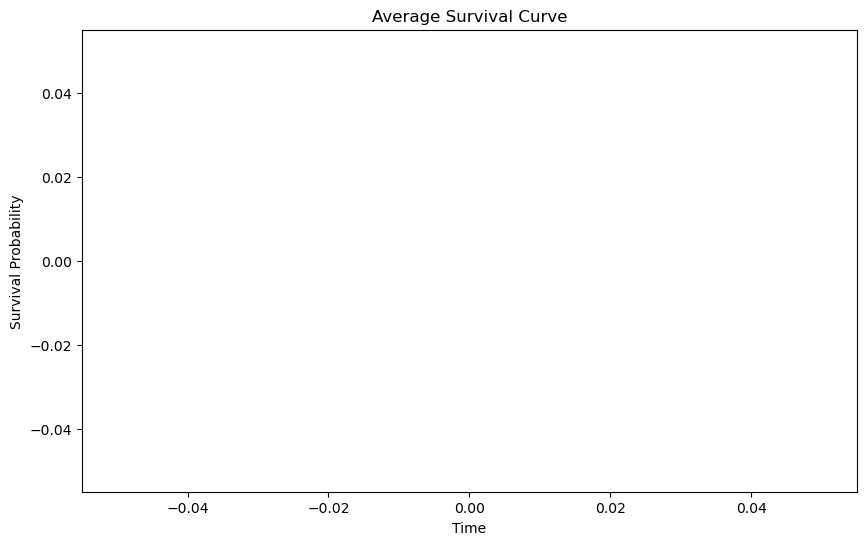

Trying without the synthetic data thing...
Training deep survival model for gbsg dataset...
Hazard model initializing...
SurvivalModel initialized.
Fitting DeepSurv model...


/Users/FDean/Desktop/CPH Background/CPH200B/cph-200b/Proiect 1/deep_survival.py:272: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(torch.clamp((1-g)/g,min=0.0,max=10.0), dtype=torch.float32) # Shape (N, 1)


Epoch 0, Loss: 55.9563
Epoch 10, Loss: 41.6893
Epoch 20, Loss: 43.8610
Epoch 30, Loss: 40.0088
Epoch 40, Loss: 31.6881
Epoch 50, Loss: 32.2835
Epoch 60, Loss: 32.1274
Epoch 70, Loss: 51.6634
Epoch 80, Loss: 21.7135


KeyboardInterrupt: 

In [27]:

for pycox_dataset in ['gbsg', 'metabric', 'nwtco', 'support', 'flchain']:
    
    print(f'Prepping {pycox_dataset} dataset')

    event_col=key_col_names[pycox_dataset][1]
    duration_col=key_col_names[pycox_dataset][0]
    
    
    df = synthetic_dfs[pycox_dataset].dropna() # Drop NAs
    df['censor_col'] = 1- df[event_col]
    
    # Train test split
    indices = torch.randperm(len(df))
    df = df.iloc[indices]
    train_df = df[:int(0.8*len(df))]
    test_df = df[int(0.8*len(df)):]
    
    # Handling non-numerical columns
    if pycox_dataset=='nwtco':
        try:
            df = df.drop(['in.subcohort'], axis=1)
        except:
            pass

    if pycox_dataset=='flchain':
        df = pd.get_dummies(df, columns=['chapter', 'sex'], drop_first=True)
    
    
    print(f'Training domain classifier for {pycox_dataset} dataset...')
    covariates = train_df.columns.drop([event_col, duration_col])
    domain_adaptation_model = DomainClassifier(input_dim=len(covariates))
    
    
    domain_adaptation_model.fit(X = train_df[covariates], y = train_df[event_col], epochs=20, batch_size=32)
    print(f'Domain classifier trained. AUC on test: {domain_adaptation_model.get_auc(test_df[covariates], test_df[event_col])}')

    print(f'Training deep survival model for {pycox_dataset} dataset...')
    DeepSurvivalModel = SurvivalModel(df = df, covariates = covariates, 
                                      censor_col='censor_col', time_col=duration_col,
                                      domain_adapatation_model = domain_adaptation_model)
    DeepSurvivalModel.fit(epochs = 100, batch_size=32)
    print('Deep survival model trained.')

    print(f'Concordance index for {pycox_dataset} test dataset:')
    print(DeepSurvivalModel.concordance_index(test_df))
    DeepSurvivalModel.plot_average_survival(test_df)

    # Seems like this framework would do better if we didn't augment data ... so also try:
    print('Trying without the synthetic data thing...')
    if pycox_dataset in ['flchain','nwtco']:
        df = getattr(datasets, pycox_dataset).read_df(processed=False)
    else:
        df = getattr(datasets, pycox_dataset).read_df()
    
    # Handling non-numerical columns
    if pycox_dataset=='nwtco':
        df = df.drop(['in.subcohort'], axis=1)

    if pycox_dataset=='flchain':
        df = pd.get_dummies(df, columns=['chapter', 'sex'], drop_first=True)
    
    df['censor_col'] = 1- df[event_col]
    
    # Train test split
    indices = torch.randperm(len(df))
    df = df.iloc[indices]
    train_df = df[:int(0.8*len(df))]
    test_df = df[int(0.8*len(df)):]

    print(f'Training deep survival model for {pycox_dataset} dataset...')
    DeepSurvivalModel = SurvivalModel(df = df, covariates = covariates, 
                                      censor_col='censor_col', time_col=duration_col,
                                      domain_adapatation_model = domain_adaptation_model)
    DeepSurvivalModel.fit(epochs = 100, batch_size=32)
    print('Deep survival model trained.')

    print(f'Concordance index for {pycox_dataset} test dataset:')
    print(DeepSurvivalModel.concordance_index(test_df))
    DeepSurvivalModel.plot_average_survival(test_df)

    print('Dropping the domain adaptation thing (not synthetic data either)...')

    # Train test split
    indices = torch.randperm(len(df))
    df = df.iloc[indices]
    train_df = df[:int(0.8*len(df))]
    test_df = df[int(0.8*len(df)):]

    print(f'Training deep survival model for {pycox_dataset} dataset without domain adaptation...')
    DeepSurvivalModel = SurvivalModel(df = df, covariates = covariates, 
                                      censor_col='censor_col', time_col=duration_col)
    DeepSurvivalModel.fit(epochs = 100, batch_size=32)
    print('Deep survival model trained.')

    print(f'Concordance index for {pycox_dataset} test dataset:')
    print(DeepSurvivalModel.concordance_index(test_df))
    DeepSurvivalModel.plot_average_survival(test_df)

    print('-------------------------------------------------------------------')
    print('-------------------------------------------------------------------')
    print('\n\n')
    print('-------------------------------------------------------------------')



I am confused why I would both augment the data and 

## References

[1] Chicco, Davide, and Giuseppe Jurman. “Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone.” BMC Medical Informatics and Decision Making, vol.
20, no. 1 (2020): 1-16.

[2] Weiss, Eric S., Lois U. Nwakanma, Stuart B. Russell, John V. Conte, and Ashish S. Shah. “Outcomes in
bicaval versus biatrial techniques in heart transplantation: an analysis of the UNOS database.” The Journal
of heart and lung transplantation, vol. 27, no. 2 (2008): 178-183.